In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append(str(Path.cwd().parent))

In [2]:
# Directory containing pickle files
directory = Path("../results/classification/quantitative")

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [3]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)

print(df.shape)



(10011, 15)


In [4]:
df_long = df.melt(
        id_vars=['name', 'random_state', 'prox_method', 'conformity_k'],
        value_vars=[
                'ice_auc', 'diff_proba_auc', 'conformity_auc',
                'ice_auc_test', 'diff_proba_auc_test', 'conformity_auc_test',
                'tree_conformity_auc', 'tree_conformity_auc_test'
        ],
        var_name='metric',
        value_name='auc'
)

In [5]:
df_long['Method'] = df_long['metric']

df_long.loc[df_long['metric'] == 'ice_auc', 'Method'] = 'RF-ICE (EMR)'
df_long.loc[(df_long['metric'] == 'conformity_auc') & (df_long['prox_method'] == 'original'), 'Method'] = 'Conformity'
df_long.loc[(df_long['metric'] == 'conformity_auc') & (df_long['prox_method'] == 'rfgap'), 'Method'] = 'RF-ICE Conformity'
df_long.loc[df_long['metric'] == 'diff_proba_auc', 'Method'] = 'Proba. Diff.'
df_long.loc[df_long['metric'] == 'tree_conformity_auc', 'Method'] = 'Tree Conformity'


methods = ['RF-ICE (EMR)', 'Conformity', 'RF-ICE Conformity', 'Proba. Diff.', 'Tree Conformity']
df_long = df_long[df_long['Method'].isin(methods)]


In [6]:
df_long_rank = df_long.groupby(['Method', 'name'])['auc'].mean().reset_index()

In [7]:
df_long_rank["auc_rank"] = df_long_rank.groupby("name")["auc"].rank(ascending=False, method="min")


In [8]:
df_long_rank.groupby(['Method'])['auc_rank'].agg(['mean', 'std']).sort_values(by = 'mean', ascending = True)

,mean,std
Method,,
RF-ICE Conformity,1.148148,0.491720
Conformity,1.192308,0.561457
Proba. Diff.,3.092593,0.852710
RF-ICE (EMR),3.648148,0.519703
Tree Conformity,4.870370,0.584268


In [9]:
df_group = df_long.groupby(['prox_method', 'conformity_k', 'metric'])['auc'].agg(['mean', 'std']).reset_index()

df_group.loc[
    df_group['metric'].isin([
        'diff_proba_auc', 'diff_proba_auc_test',
        'tree_conformity_auc', 'tree_conformity_auc_test'
    ]),
    'prox_method'
] = 'NA'


# Subset for the compared methods


df_group['Method'] = df_group['metric']

df_group.loc[df_group['metric'] == 'ice_auc', 'Method'] = 'RF-ICE (EMR)'
df_group.loc[(df_group['metric'] == 'conformity_auc') & (df_group['prox_method'] == 'original'), 'Method'] = 'Conformity'
df_group.loc[(df_group['metric'] == 'conformity_auc') & (df_group['prox_method'] == 'rfgap'), 'Method'] = 'RF-ICE Conformity'
df_group.loc[df_group['metric'] == 'diff_proba_auc', 'Method'] = 'Proba. Diff.'
df_group.loc[df_group['metric'] == 'tree_conformity_auc', 'Method'] = 'Tree Conformity'

# Carefull with this one!
methods = ['RF-ICE (EMR)', 'Conformity', 'RF-ICE Conformity', 'Proba. Diff.', 'Tree Conformity']
df_group = df_group[df_group['Method'].isin(methods)]
# df_group.drop(columns=['prox_method', 'conformity_k', 'metric'], inplace=True)

df_group.reset_index(drop = True, inplace=True)

In [10]:
df_group

,prox_method,conformity_k,metric,mean,std,Method
0,NA,1,diff_proba_auc,0.926252,0.130280,Proba. Diff.
1,oob,1,ice_auc,0.930008,0.108878,RF-ICE (EMR)
2,NA,1,tree_conformity_auc,0.712665,0.214876,Tree Conformity
3,NA,5,diff_proba_auc,0.926252,0.130280,Proba. Diff.
4,oob,5,ice_auc,0.930008,0.108878,RF-ICE (EMR)
...,...,...,...,...,...,...
83,NA,200,tree_conformity_auc,0.768926,0.162566,Tree Conformity
84,rfgap,500,conformity_auc,0.982098,0.031363,RF-ICE Conformity
85,NA,500,diff_proba_auc,0.937295,0.092798,Proba. Diff.
86,rfgap,500,ice_auc,0.934313,0.085554,RF-ICE (EMR)


In [11]:
df_group.groupby(['Method'])['mean'].median()

Method
Conformity           0.966429
Proba. Diff.         0.926847
RF-ICE (EMR)         0.930568
RF-ICE Conformity    0.966934
Tree Conformity      0.717134
Name: mean, dtype: float64

In [12]:
# df_group = df_group[df_group['conformity_k'] > 10]

In [13]:
df_group.groupby('Method')[['mean', 'std']].mean().sort_values('mean', ascending=False)

,mean,std
Method,,
RF-ICE Conformity,0.965399,0.067835
Conformity,0.964216,0.068620
RF-ICE (EMR),0.931740,0.098844
Proba. Diff.,0.928660,0.118131
Tree Conformity,0.730255,0.195985


In [14]:
df_latex = df_group.groupby('Method')[['mean', 'std']].mean().sort_values('mean', ascending=False).reset_index()
df_latex['AUC'] = df_latex.apply(lambda row: f"{row['mean']:.3f} ± {row['std']:.3f}", axis=1)
latex_table = df_latex[['Method', 'AUC']].to_latex(index=False)
print(latex_table)


\begin{tabular}{ll}
\toprule
Method & AUC \\
\midrule
RF-ICE Conformity & 0.965 ± 0.068 \\
Conformity & 0.964 ± 0.069 \\
RF-ICE (EMR) & 0.932 ± 0.099 \\
Proba. Diff. & 0.929 ± 0.118 \\
Tree Conformity & 0.730 ± 0.196 \\
\bottomrule
\end{tabular}



/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper 

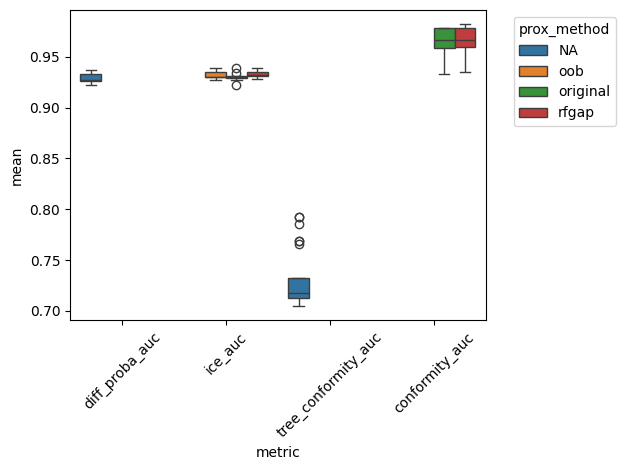

In [15]:
sns.boxplot(
    # data=df_group[df_group['prox_method'] != 'oob'],
    data = df_group,
    # data = df_group[df_group['conformity_k'] == 20],
    x='metric', y='mean', hue='prox_method'
)
plt.xticks(rotation=45)
plt.legend(title='prox_method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [16]:
## Acc. Rej. Curve Example

file_path = "../results/classification/qualitative/analcatdata_authorship_oob_k20_rs54887.pkl"

with open(file_path, "rb") as f:
    data = pickle.load(f)


<Axes: >

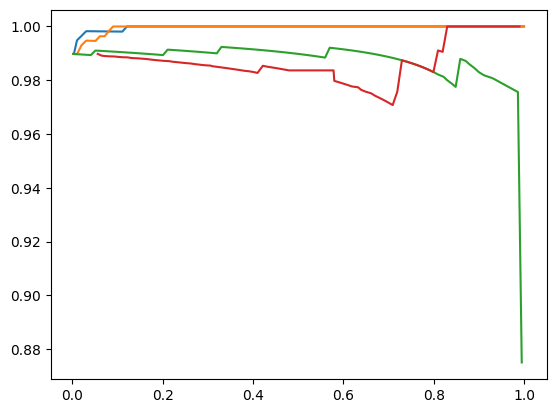

In [17]:
sns.lineplot(
             x = data['diff_proba_n_drop'],
             y = data['diff_proba_accuarcy_drop']
)

sns.lineplot(
             x = data['conformity_n_drop'],
             y = data['conformity_accuracy_drop']
)

sns.lineplot(
             x = data['ice_n_drop'],
             y = data['ice_accuracy_drop']
)

sns.lineplot(
             x = data['tree_conformity_n_drop'],
             y = data['tree_conformity_accuracy_drop']
)


In [18]:
data.keys()

dict_keys(['prox_method', 'conformity_k', 'random_state', 'oob_score_', 'diff_proba_auc', 'diff_proba_auc_test', 'conformity_auc', 'conformity_auc_test', 'diff_proba_accuarcy_drop', 'diff_proba_n_drop', 'diff_proba_accuracy_drop_test', 'diff_proba_n_drop_test', 'conformity_accuracy_drop', 'conformity_n_drop', 'conformity_accuracy_drop_test', 'conformity_n_drop_test', 'ice_auc', 'ice_auc_test', 'ice_accuracy_drop', 'ice_n_drop', 'ice_accuracy_drop_test', 'ice_n_drop_test', 'tree_conformity', 'tree_conformity_test', 'tree_conformity_accuracy_drop', 'tree_conformity_accuracy_drop_test', 'tree_conformity_n_drop', 'tree_conformity_n_drop_test', 'tree_conformity_auc', 'tree_conformity_auc_test', 'name', 'n_features', 'n_samples'])